# Power Systems Calculation Package: Myriad

[Intro text here]

In [8]:
# Some graphics processing
import xml.etree.ElementTree as ET
from IPython.display import SVG, display, HTML
import matplotlib.pyplot as plt

import power_system_simulation.graph_processing as pss
import power_system_simulation.optimization as psso
from power_grid_model.utils import json_deserialize, json_serialize

import time
import re
import json
import pandas as pd
    
red = '#f54040'
green = '#86fc53'
blue = '#1cd5ff'

svg_content = ''

def update_style(svg_code, element_id, new_style):
    pattern = f'(<[^>]+id="{element_id}"[^>]+style=")[^"]*(")'
    replacement = f''
    if "e" in element_id:
        replacement = f'\\1stroke:{new_style}\\2'
    elif "v" in element_id:
        replacement = f'\\1fill:{new_style}\\2'
        
    updated_svg_code = re.sub(pattern, replacement, svg_code)
    updated_svg_code = re.sub(f'(<[^>]+id="t{element_id}"[^>]+style=")[^"]*(")', f'\\1fill:{new_style}\\2', updated_svg_code)
        
    return updated_svg_code

def update():
    global svg_content
    style = "<style>svg{width:50px !important;height:50px !important;</style>"
    display(SVG(svg_content), clear=True)

def blink_edges(edge_ids, delay, times=5, color='#f54040'):
    for i in range(times):
        svg_content_a = svg_content
        svg_content_b = svg_content
        
        for edge in edge_ids:
            svg_content_a=update_style(svg_content_a, f'e{edge}', color)
        display(SVG(svg_content_a), clear=True)
        time.sleep(delay)
        for edge in edge_ids:
            svg_content_b=update_style(svg_content_b, f'e{edge}', 'gray')
        display(SVG(svg_content_b), clear=True)
        time.sleep(delay)
        
def blink_vertices(vertex_ids, delay, times=5, color='#f54040'):
    for i in range(times):
        svg_content_a = svg_content
        svg_content_b = svg_content
        
        for vertex in vertex_ids:
            svg_content_a=update_style(svg_content_a, f'v{vertex}', color)
        display(SVG(svg_content_a), clear=True)
        time.sleep(delay)
        for vertex in vertex_ids:
            svg_content_b=update_style(svg_content_b, f'v{vertex}', 'white')
        display(SVG(svg_content_b), clear=True)
        time.sleep(delay)
        
def highlight_disabled_edges(gp):
    global svg_content
    for edge_index in range(len(gp.edge_ids)):
        if gp.edge_enabled[edge_index] == False:
            svg_content = update_style(svg_content, f'e{gp.edge_ids[edge_index]}', '#f54040')
            update()
            
def visualizer_init(gp):
    global svg_content
    
    with open('Asset 1.svg', 'r') as file:
        svg_content = file.read()
    
    for edge_index in range(len(gp.edge_ids)):
        if gp.edge_enabled[edge_index] == False:
            svg_content = update_style(svg_content, f'e{gp.edge_ids[edge_index]}', '#303030')
    update()
            
def highlight_edge(edge_id, color='#86fc53'):
    global svg_content
    svg_content = update_style(svg_content, f'e{edge_id}', color)
    update()
    
def highlight_vertex(vertex_id, color='#86fc53'):
    global svg_content
    svg_content = update_style(svg_content, f'v{vertex_id}', color)
    update()
    
def visualizer_alternative_edge(gp, edge_id):
    highlight_edge(edge_id, red)
    alternative_edges = gp.find_alternative_edges(edge_id)
    for edge in alternative_edges:
        highlight_edge(edge, color=green)
    
def visualizer_downstream_vertices(gp, edge_id):
    highlight_edge(edge_id, red)
    downstream_vertices = gp.find_downstream_vertices(edge_id)
    for vertex in downstream_vertices:
        highlight_vertex(vertex, color=green)
        
#def visualizer_downstream_vertices_algorithm(gp, edge_id):
    

In [3]:
# Import the dataset
src_dir = "M:/TUE/PowerSystemComputationAndSimulation/input_big_dataset"
ev_dir = "M:/TUE/PowerSystemComputationAndSimulation/output_big_dataset_ev"

meta_data = {}
network_data = {}
active_profile = {}
reactive_profile = {}
ev_active_profile = {}

def load_big_dataset():
    global network_data, meta_data, active_profile, reactive_profile, ev_active_profile
    dir_meta_data_json = src_dir + "/meta_data.json"
    dir_network_json = src_dir + "/input_network_data.json"
    dir_active_profile = src_dir + "/active_power_profile.parquet"
    dir_reactive_profile = src_dir + "/reactive_power_profile.parquet"
    dir_ev_active_profile = src_dir + "/ev_active_power_profile.parquet"

    with open(dir_meta_data_json) as fp:
        data = fp.read()
    meta_data = json.loads(data)

    with open(dir_network_json) as fp:
        data = fp.read()
    network_data = json_deserialize(data)

    active_profile = pd.read_parquet(dir_active_profile)
    reactive_profile = pd.read_parquet(dir_reactive_profile)
    ev_active_profile = pd.read_parquet(dir_ev_active_profile)

load_big_dataset() # Only works if directories are set correctly

## General Overview

This package includes multiple types of functions, some of the important ones are:
- EV Penetration calculations
- Optimal tap position calculation
- Alternative edge searching
- Testing
- Teamwork

***

## EV Penetration

The main goal of this function is to randomly assign EV (electrical vehicle) charging profiles to houses that have a sym_load,
given a user-provided input for the penetration level. 

This can be done step-by-step, beginning with the conversion of the input data. This is done because the Downstream Vertices function from assignment 1 is also used for this function:

```python
# Make Graphprocessing instance to draw the graph
vertex_ids = [node[0] for node in self.pgm_input["node"]]
edge_ids = [edge[0] for edge in self.pgm_input["line"]]
edge_vertex_id_pairs = [(edge[1], edge[2]) for edge in self.pgm_input["line"]]
edge_enabled = [(edge[3] == 1 and edge[4] == 1) for edge in self.pgm_input["line"]]
source_vertex_id = self.pgm_input["source"][0][1]

# Pretend all transformers are short circuits, so that GraphProcessor can use it
for transformer in self.pgm_input["transformer"]:
    edge_vertex_id_pairs.append((transformer[1], transformer[2]))
    edge_enabled.append(True)
    edge_ids.append(transformer[0])
gp = pss.GraphProcessor(
    vertex_ids, edge_ids, edge_vertex_id_pairs, edge_enabled, source_vertex_id
)
```
Now that we have converted the given input data, we can initialize a graph processor object:

```python 
gp = pss.GraphProcessor(
    vertex_ids, edge_ids, edge_vertex_id_pairs, edge_enabled, source_vertex_id
)
```
Now the Downstream Vertices function from assignment 1 can be used to find which nodes belong to which LV feeders:

```python
# See which feeder has which nodes
        for feeder_id in self.meta_data["lv_feeders"]:
            feeders.append(feeder_id)
            feeder_nodes[feeder_id] = gp.find_downstream_vertices(feeder_id)
```
 
After finding which nodes belong to which LV feeders, the calculation can be shown in a couple of points:
- Calculating the amount of EV-houses per LV feeder
    - The amount of EV-houses per LV feeder is calculated using: ``math.floor(penetration_level * total_houses / total_feeders)`` in order to round down to the nearest intiger.
- Finding which of the nodes are houses for each LV feeder.
    - This is done by checking which node ID's match the ID's in sym_load from the input data and then assigning only those to their corresponding LV feeder.
- Randomly choose houses that will get an EV charger.
    - Using the random.sample function to assign multiple random profiles to houses, making sure that there are no repetitives.
- Assign random EV charging profiles to the chosen houses 
    - This time using the random.shuffle with a for loop was needed to randomly choose a profile for each house without repetitives.
- Assign sym_load nodes to input_network_data.json IDs
- Modify the active and reactive load profile according to the EV house profile
- Run a time-series power flow and return the two aggregation tables
    - Using the functions create_update_model, run_batch_process, and get_aggregate_results from Assignment 2 to print the tables as Dataframes.


### Downstream Vertices Algorithm

Milan: [Explain how the algorithm works]

### Downstream Vertices Algorithm Steps

- Remove the input edge from the id_pairs list
- Find the islands
- Check which remaining islands contain the source vertex, the other island is our output

Or in code form:
```python
# Create two islands by seperating the graph at the input edge
edge_list.remove(input_edge)

islands = calculate_islands()

for island in islands:
    if not island.contains(source_vertex):
        return island
```

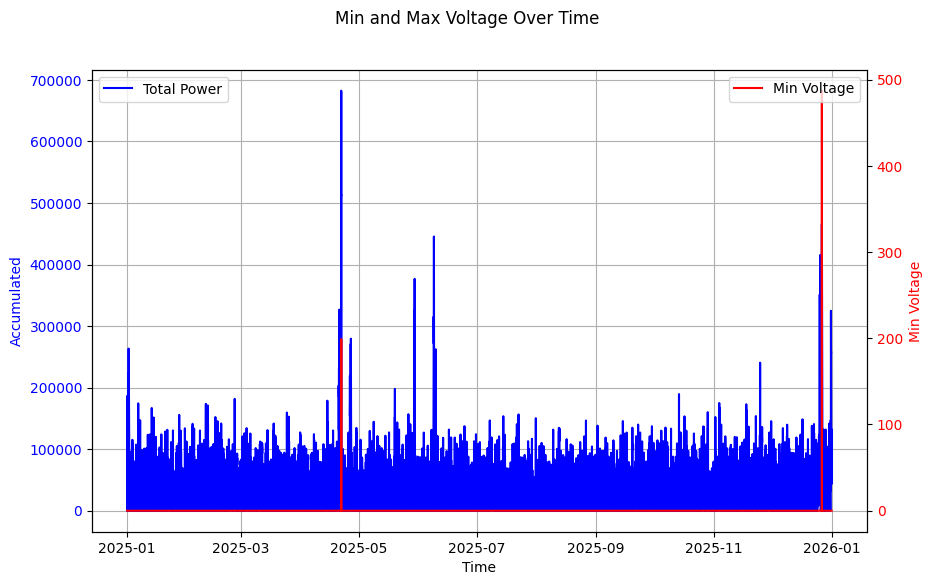

In [90]:
vertex_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
edge_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
edge_vertex_id_pairs = [
    (1, 2), (2, 3), (2, 7), (3, 4), (4, 5), (5, 6), (3, 8), (8, 9), (9, 10), (8, 11), (11, 12), (5, 10)
]
edge_enabled = [True, True, True, True, True, True, True, True, True, True, True, False]
source_vertex_id = 1

gp = pss.GraphProcessor(
    vertex_ids, edge_ids, edge_vertex_id_pairs, edge_enabled, source_vertex_id
)

pgm = psso.LV_grid(
    network_data, active_profile, reactive_profile, ev_active_profile, meta_data
)

ev_results_line = pd.read_parquet(ev_dir + "/calculated_output_per_line.parquet")
ev_results_timestamp = pd.read_parquet(ev_dir + "/calculated_output_per_timestamp.parquet")
ev_profiles = pd.read_parquet(src_dir + "/ev_active_power_profile.parquet")
ev_accumulated = pd.read_parquet(ev_dir + "/calculated_accumulated_ev.parquet")

# length = len(ev_profiles.index)
# acc = [0] * length
# i = 0
# for timestamp in ev_profiles.index:
#     for ev in ev_profiles.columns:
#         acc[i] += ev_profiles.loc[timestamp, ev]
#     i += 1
#     print(i)

# # Create figure and axis objects
# fig, ax1 = plt.subplots(figsize=(10, 6))

# # Plot Min_Voltage on ax1
# ax1.plot(ev_accumulated.index, ev_accumulated['Accumulated'], color='b', label='Total Power')
# ax1.set_xlabel('Time')
# ax1.set_ylabel('Accumulated', color='b')
# ax1.tick_params(axis='y', labelcolor='b')

# # Create a second y-axis sharing the same x-axis
# ax2 = ax1.twinx()
# ax2.plot(ev_results_timestamp.index, ev_results_timestamp['Min_Voltage_Node'], color='r', label='Min Voltage')
# ax2.set_ylabel('Min Voltage', color='r')
# ax2.tick_params(axis='y', labelcolor='r')

# # Add titles and legends
# fig.suptitle('Min and Max Voltage Over Time')
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')

# # Show grid
# ax1.grid(True)

# # Display the plot
# plt.show()

# visualizer_init(gp)

# visualizer_downstream_vertices(gp, 2)

# time.sleep(1)

### Applying EV Penetration calculations to a big dataset

Kacper: [Show graphs of node voltages changing when an EV charger turns on? Some other ideas?]

***

## Optimal Tap Position Calculation

Kacper: [Explain stuff]

___

## N-1 Calculation: Alternative grid topology

    Mels: [Explain how the code works]
In this function an edge is disconnected. The goal is to find a table where different alternative edges can be compared. 
For this, a conversion of the input data is required. This way, the functions made in Assignment 1 can be used:
```python 
vertex_ids = [node[0] for node in self.pgm_input["node"]]
edge_ids = [edge[0] for edge in self.pgm_input["line"]]
edge_vertex_id_pairs = [(edge[1], edge[2]) for edge in self.pgm_input["line"]]
edge_enabled = [(edge[3] == 1 and edge[4] == 1) for edge in self.pgm_input["line"]]
source_vertex_id = self.pgm_input["source"][0][1]
``` 
In this assignment we also have transformers. For the purpose of this function, these will be considered as normal edges and will be added to the edge_ids list:
```python 
for transformer in self.pgm_input["transformer"]:
    edge_ids.append(transformer)
```
Now that we have converted the given input data, we can initialize a graph processor object:
```python 
gp = pss.GraphProcessor(
    vertex_ids, edge_ids, edge_vertex_id_pairs, edge_enabled, source_vertex_id
)
```
Using the object, we are now able to call: 
```python 
gp.find_alternative_edges(line_id)
```
The function above was written for Assignment 1.
For now we know that this function returns a list of all alternative edges. A more in depth explanation will be given shortly.
A constraint of the power system is that: 
```python
"6. The graph should be fully connected."
```
If we would disable an edge, the function looks for all alternative edges it can enable to have the system be fully connected again, thus following the mentioned contraint of the system. 
The function returns a list. For each alternative edge in that list, N-1 calculation will do as the name suggest, calculations. This is done using functions created in assignment 2. Since these have already been explained. A better way to finish this explanation is to tell what we do with the output of those functions.
We give each alternative edge a row with:
- The alternative Line ID to be connected
- The maximum loading in Watt among all lines and timestamps
- The Line ID of this maximum
- The timestamp of this maximum

Multiple alternative edges means that the table will consist of multiple rows. No alternative edges means that there are no rows in the table and thus having an empty one.

    Milan or Mels: [Explain the algorithm, possibly using the visualization functions Milan wrote]

### Alternative Edge Algorithm Steps

- Get a list of all the disabled edges
- Loop through the list of disabled edges, and one by one enable each disabled edge
- Check if the graph is fully connected and non-circular
- If it is, add it to the list of alternative edges

Or in code form:
```python
alternative_edges = []
disabled_edge_list = []

edge_list.disable_edge(input_edge)

for edge in edge_list:
    if is_disabled(edge) is True:
        disabled_edge_list.append(edge)

for edge in disabled_edge_list:
    # Temporarily enable edge
    edge_list.enable_edge(edge)

    if not graph.isCyclic() and graph.isFullyConnected():
        alternative_edges.append(edge)
```

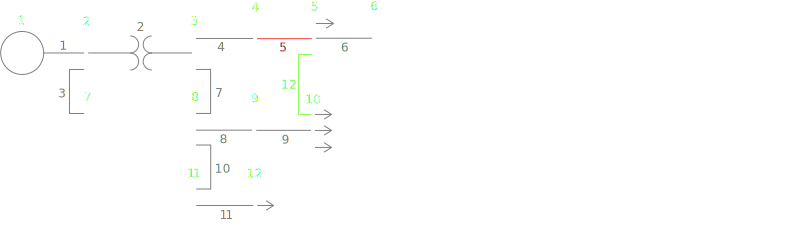

In [ ]:
visualizer_init(gp)

visualizer_alternative_edge(gp, 5)

***

## Testing

Badr or Arif: [Explain how we test the functions, explain how we test errors, and how we make sure the alternative_edge function for example gives the right answer. Maybe also explain how we had 2 functions for downstream_vertices and we tested which one was the fastest?]

Testing the functions was done seperately between the assignments. In the very first assignment the downstream vertices and alternative edges functions are tested, also including some important errors. 

What basically has been done is that certain test cases are written in which the code should raise an error. For example when we check if all edges are unique, we make a case where this is not valid:

```python
# Non-unique edge-ID
t_edge_ids = [1, 3, 5, 7, 8, 8]
with pytest.raises(pss.IDNotUniqueError, match=r".*T1"):
    pss.GraphProcessor(
        vertex_ids, t_edge_ids, edge_vertex_id_pairs, edge_enabled, source_vertex_id
    )
```
And the same was done for all the other errors, but also for the two functions. These two functions are done differently however; 
We create graphs and compare the functions output with the intended output of what the functions are supposed to give. For example a case for alternative edges is tested like this:

```python
def test_alternative_edges():
    # Graph being made for the testing of this function 
    vertex_ids = [0, 2, 4, 6, 10]
    edge_ids = [1, 3, 5, 7, 8, 9]
    edge_vertex_id_pairs = [(0, 2), (0, 4), (0, 6), (2, 4), (4, 6), (2, 10)]
    edge_enabled = [True, True, True, False, False, True]
    source_vertex_id = 0

    gp = pss.GraphProcessor(
        vertex_ids, edge_ids, edge_vertex_id_pairs, edge_enabled, source_vertex_id
    )
    # When the functions is called, the alternative edge it should
    # give is edge 7 when edge 1 is being disabled
    assert set(gp.find_alternative_edges(1)) == set([7])
```
The graph that is being made looks like this:
```python
# vertex_0 (source) --edge_1(enabled)-- vertex_2 --edge_9(enabled)-- vertex_10
#                  |                               |
#                  |                           edge_7(disabled)
#                  |                               |
#                  -----------edge_3(enabled)-- vertex_4
#                  |                               |
#                  |                           edge_8(disabled)
#                  |                               |
#                  -----------edge_5(enabled)-- vertex_6
```
When the intended results match the results that is provided by our function reconfirms that the functions are working as intended.

For assignment 2 the same thing was done with the errors, but the functions are different. What now is done is that the results of the tables are being compared with the provided results of the given data. Here is and example of an error where there is a mismatch in timestamps:
```python
# Change a timestamp in active profile to an incorrect one and check for error
active_load_profile_wrong = active_load_profile.copy()
active_load_profile_wrong.rename(
    index={active_load_profile.index[0]: pd.to_datetime("today").normalize()}, inplace=True
)
with pytest.raises(pgm_p.ProfilesDontMatchError, match=r".*T0") as excinfo:
    p = pgm_p.PgmProcessor(network_data, active_load_profile_wrong, reactive_load_profile)
    p.create_update_model()
```
Below is also something similar as assignment 1, but now the resulting tables are being compared to the provided tables of the data:

```python
assert (
    p.compare_to_expected(
        aggregate_results,
        pd.read_parquet(dir_out_per_line),
        pd.read_parquet(dir_out_per_timestamp),
    )
    == True
)
# Change the output data and check if the error is detected
with pytest.raises(AssertionError) as excinfo:
    assert (
        p.compare_to_expected(
            aggregate_results,
            pd.read_parquet(dir_out_per_line),
            pd.read_parquet(dir_out_per_line),
        )
        == True
    )
```

The testing of assignment 3 is a combination of the already existing classes and functions. 
The input data is checked for multiple different types of errors to make sure that the data is valid.
An example for this is the error check below:
```python
# 10 The number of EV charging profile is at least the same as the number of sym_load.
test_number_EV = copy.deepcopy(ev_active_profile)
new_column = copy.deepcopy(test_number_EV[1])
test_number_EV[4] = new_column
with pytest.raises(psso.EvProfilesDontMatchSymLoad) as excinfo:
    psso.LV_grid(network_data, active_profile, reactive_profile, test_number_EV, meta_data)
```
It is practically done the same as in assignment 1 and 2, but here the input data is altered to where it should give an error.
Furthermore, the testing of the functions are kind of already done in the previous assignments so it was not necessarily needed to test them again, except for the optimal tap postition. In the optimal tap position the calculated position is compared with the intended position to see whether the function is working as intended.
***


## Teamwork

Someone?: [Explain how we worked together, using github and regular meetings and stuff, maybe planning etc]